In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch
from lsh import LSH

In [2]:
from torchinterp import Interp1d

In [3]:
df_train = pd.read_csv("../dataset/pointcloud_mnist_2d/train.csv")
df_test = pd.read_csv("../dataset/pointcloud_mnist_2d/test.csv")

X = df_train[df_train.columns[1:]].to_numpy()
y = df_train[df_train.columns[0]].to_numpy()

X = X.reshape(X.shape[0], -1, 3)

X.shape, y.shape

((60000, 351, 3), (60000,))

In [4]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [5]:
# set size of each sample
sizes = torch.sum((X[:, :, 2] > 0).long(), dim=1).unsqueeze(1)

In [6]:
X = X[:, :, 0:2]

In [7]:
def compute_fcp(X, sizes):
    max_num_elmts = X.shape[1]
    
    ref_domain = torch.linspace(0, 1, max_num_elmts)
    
    # a self-defined reference function to interpolate against; original paper uses learnable weights
    # y = 2x (0 < x < 0.5) ; y = -2x + 2 (x >= 0.5) is used here, which was used as an example in their talk.  
    ref_lrange_0 = (ref_domain[ref_domain < 0.5] * 2)
    ref_rrange_0 = (ref_domain[ref_domain >= 0.5] * -2 + 2)

    # ref_range_0 = torch.randn(max_num_elmts, )
    # ref_range_0 = torch.cat((ref_lrange_0, ref_rrange_0), dim=0)
    # ref_range_1 = ref_range_0 = torch.ones(max_num_elmts) * 0.5
    ref_range_0 = ref_domain
    ref_range_1 = ref_domain  
    
    X_sorted, _ = torch.sort(X, dim=1, descending=True)
    X_wx = torch.arange(0, max_num_elmts).repeat(X.shape[0], 1) / sizes
    
    mask = X_wx <= 1
    X_wx[X_wx > 1] = 0
    X_w0 = Interp1d()(ref_domain, ref_range_0, X_wx.T).T
    X_w1 = Interp1d()(ref_domain, ref_range_1, X_wx.T).T
    
    X_w = torch.stack((X_w0, X_w1), dim=-1)
    
    X_fcp = (X_sorted * X_w * mask.long().unsqueeze(-1)).sum(1)
    return X_fcp

In [8]:
X_fcp_np = compute_fcp(X, sizes).numpy()

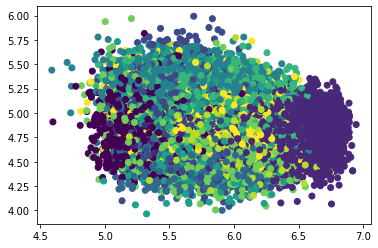

In [9]:
X_fcp_np = compute_fcp(X, sizes).numpy() / sizes
# X_fcp_np = compute_fcp(X, sizes).numpy()
plt.scatter(X_fcp_np[:, 0], X_fcp_np[:, 1], c=y.tolist())
plt.show()

In [10]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# didn't use LHSForest because according to documentation, it has been deprecated due to poor performance. 
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_fcp_np, y.numpy())

KNeighborsClassifier(n_neighbors=1)

In [12]:
X_test = df_test[df_test.columns[1:]].to_numpy()
y_test = df_test[df_test.columns[0]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], -1, 3)

In [13]:
X_test = torch.from_numpy(X_test)

test_sizes = torch.sum((X_test[:, :, 2] > 0).long(), dim=1).unsqueeze(1)
X_test = X_test[:, :, :2]

In [14]:
X_test.shape

torch.Size([10000, 351, 2])

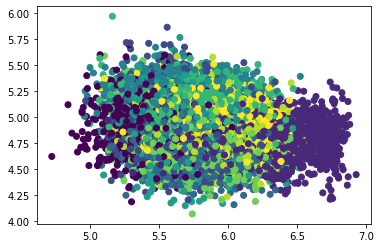

In [15]:
X_test_fcp_np = compute_fcp(X_test, test_sizes).numpy() / test_sizes
# X_test_fcp_np = compute_fcp(X_test, test_sizes).numpy()
plt.scatter(X_test_fcp_np[:, 0], X_test_fcp_np[:, 1], c=y_test.tolist())
plt.show()

In [16]:
preds = neigh.predict(X_test_fcp_np)

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
accs = []
num_neighs = 20
for i in range(1, num_neighs):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_fcp_np, y.numpy())
    preds = neigh.predict(X_test_fcp_np)
    accs.append(accuracy_score(preds, y_test))

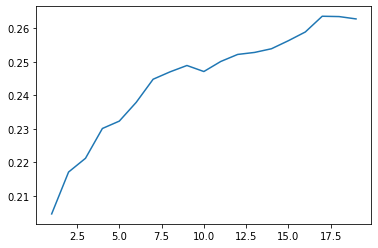

In [19]:
plt.plot(range(1, num_neighs), accs)
plt.show()

In [20]:
accuracy_score(preds, y_test)

0.2628

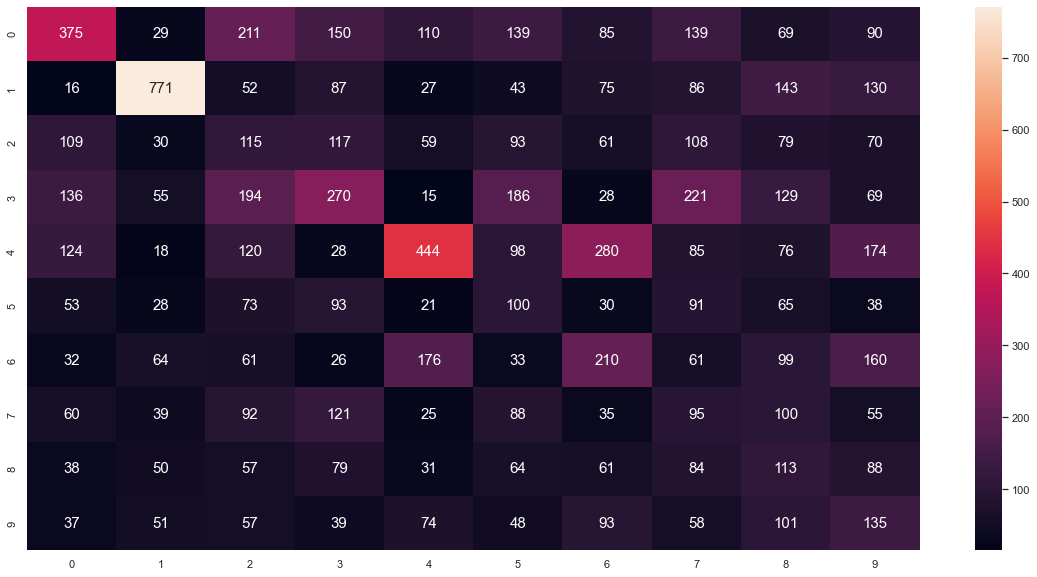

In [21]:
import seaborn as sn
cm = confusion_matrix(preds, y_test)

df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize=(20,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g')

plt.show()